In [92]:
from altaipony.lcio import from_mast, from_path
from altaipony.injrecanalysis import plot_heatmap, tile_up_injection_recovery
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve

import pytest
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.funcs import write_flares_to_file, read_custom_aperture_lc, get_window_length_dict
from funcs.custom_detrending import custom_detrending, search_gaps_for_window_length, refine_detrended_flux_err

import copy


from scipy.interpolate import UnivariateSpline

In [2]:
clcs = ! ls /home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/custom_aperture/*fits
clcs = [x.split("/")[-1] for x in clcs]

def get_customlc(TIC, c, clcs):
    for p in clcs:
        if (str(TIC) in p.split("-")[2]) & (c == int(p.split("-")[1][1:])):
            print(p)
            pac = p
    return pac



In [ ]:
paths = ! ls ../TESS_UCDs/injrec/
ids = [p.split("_")[2]for p in paths]
cs = [p.split("_")[3][:-4]for p in paths]
targs = list(zip(ids,cs))
targs = list(set(targs))
len(targs)
targs

In [ ]:
TIC, c = targs[0]
df = pd.DataFrame()
for p in paths:
    if ((TIC in p) & (c in p)):
        df = df.append(pd.read_csv("/work1/eilin/TESS_UCDs/injrec/"+p), ignore_index=True)

In [ ]:
bins = 25
dff, val = tile_up_injection_recovery(df, "recovery_probability",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID=TIC);
dff, val = tile_up_injection_recovery(df, "ed_ratio",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID=TIC);

In [3]:
TIC = 328254412
c = 4
clcs

['0ca_tess2019082014090-s0001-0000000029780677-0000-s_lc.fits',
 '100ca_tess2019090910225-s0007-0000000318801864-0000-s_lc.fits',
 '101ca_tess2019090910464-s0007-0000000366567664-0000-s_lc.fits',
 '102ca_tess2019090910530-s0007-0000000410898932-0000-s_lc.fits',
 '103ca_tess2019090910582-s0008-0000000000926898-0000-s_lc.fits',
 '103ca_tess2019102415201-s0008-0000000000926898-0000-s_lc.fits',
 '104ca_tess2019090911104-s0008-0000000007975441-0000-s_lc.fits',
 '105ca_tess2019090911241-s0008-0000000011654435-0000-s_lc.fits',
 '106ca_tess2019090911283-s0008-0000000044984200-0000-s_lc.fits',
 '107ca_tess2019100910514-s0008-0000000130414729-0000-s_lc.fits',
 '108ca_tess2019090911533-s0008-0000000142052876-0000-s_lc.fits',
 '108ca_tess2019102509445-s0008-0000000142052876-0000-s_lc.fits',
 '109ca_tess2019090911560-s0008-0000000167894019-0000-s_lc.fits',
 '109ca_tess2019102510083-s0008-0000000167894019-0000-s_lc.fits',
 '10ca_tess2019100710504-s0001-0000000401984769-0000-s_lc.fits',
 '110ca_tess2

In [4]:
pac = get_customlc(TIC, c, clcs)
print(pac)
pac = "/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/custom_aperture/" + pac

56ca_tess2019090610330-s0004-0000000328254412-0000-s_lc.fits
56ca_tess2019090610330-s0004-0000000328254412-0000-s_lc.fits


In [90]:
#------ Find flares -------------------------------------------------------------

#d = get_window_length_dict()

flc = read_custom_aperture_lc(pac)


pg = flc.remove_nans().to_periodogram(freq_unit=1/u.day, maximum_frequency=10, minimum_frequency=0.5)

flc = flc[np.invert(np.isnan(flc.flux))]
params, params_covariance = optimize.curve_fit(test_func, flc.time, flc.flux,
                                               p0=[np.nanstd(flc.flux), 2*np.pi*pg.frequency_at_max_power.value,
                                                   0,np.nanmean(flc.flux)])

flc.flux[:] = np.nanmean(flc.flux)+flc.flux-test_func(flc.time, params[0], params[1], params[2], params[3])

w = search_gaps_for_window_length(flc)
print(w)
flcd = custom_detrending(flc, d={flc.targetid:tuple(w)})

flcd = refine_detrended_flux_err(flcd)

flcd = flcd.find_flares()

#--------------------------------------------------------------------------------

print("\nFinished TIC {} ({})\n------------------------------\n".format(TIC, flc.campaign))

/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/tessenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/custom_aperture/56ca_tess2019090610330-s0004-0000000328254412-0000-s_lc.fits' mode='rb' closefd=True>
  """


[1793, 25, 161]


Found 3 candidate(s) in the (0,5375) gap.
Found 0 candidate(s) in the (5375,6569) gap.
Found 2 candidate(s) in the (6569,15250) gap.



Finished TIC 328254412 (4)
------------------------------



/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/tessenv/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


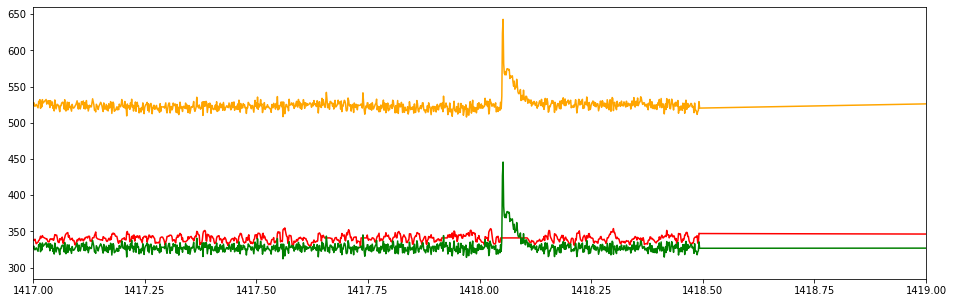

In [91]:
plt.figure(figsize=(16,5))
f = 5

plt.plot(flc.time, flc.flux+f*40, c="orange");
plt.plot(flcd.time, flcd.it_med+3*flcd.detrended_flux_err, c="r");
plt.plot(flcd.time, flcd.detrended_flux, c="g");
plt.xlim(1417,1419);
#plt.ylim(1400,2250)

In [ ]:
flcd.fake_flares = df
flcd = flcd.characterize_flares(ampl_bins=bins, dur_bins=bins)

In [ ]:
flcd.flares.sort_values(by="ampl_rec").head().T

In [ ]:
with open("/work1/eilin/TESS_UCDs/TESS_UCD_flares/flare_tables/vetted_flares.csv", "a") as f:
    flcd.flares.to_csv(f, index=False, header=False)

(2024.5, 2025.5)

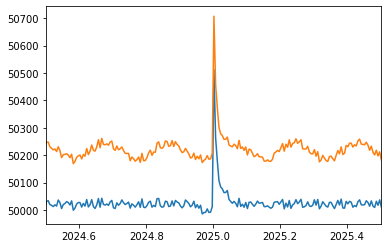

In [57]:
N = int(1e4)
time = np.linspace(2000,2050,N)
flux = np.sin(time / .03) * 30. + 5e4 + np.random.rand(N) * 35. + 5e-4 * ((time-2004.)**3 - 30 * (time-2004)**2)
flux[5000:5010] = flux[5000:5010] + np.array([500,250,150,80,60,30,20,10,7,4])
flux[4500:4809] = np.nan
flux_err = np.random.rand(N) * 10.
flc = FlareLightCurve(targetid=10000009, time=time, flux=flux, flux_err=flux_err)
flcd = flc.detrend("savgol", window_length=25)
plt.plot(flcd.time, flcd.detrended_flux)
plt.plot(flcd.time, flcd.flux+200)
plt.xlim(2024.5,2025.5)


(<Quantity 5.304 1 / d>,
 <Quantity 29.77052795>,
 <Quantity 10.76300108>,
 <Quantity 5.304 1 / d>)

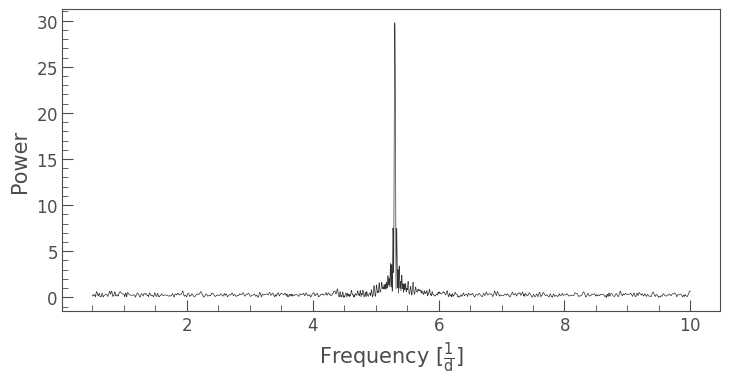

In [59]:
import astropy.units as u
pg = flc.remove_nans().to_periodogram(freq_unit=1/u.day, maximum_frequency=10, minimum_frequency=0.5)

pg.plot()
pg.frequency_at_max_power, pg.max_power, pg.flatten().max_power, pg.flatten().frequency_at_max_power

(2024, 2026)

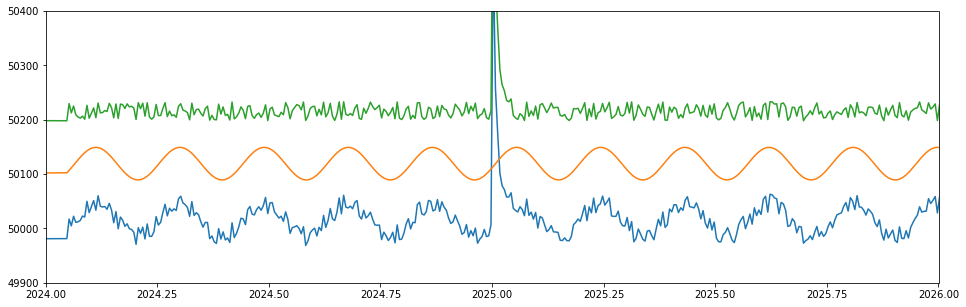

In [89]:
from scipy import optimize

def test_func(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

flc = flc[np.invert(np.isnan(flc.flux))]
params, params_covariance = optimize.curve_fit(test_func, flc.time, flc.flux,
                                               p0=[np.nanstd(flc.flux), 2*np.pi*pg.frequency_at_max_power.value,
                                                   0,np.nanmean(flc.flux)])

plt.figure(figsize=(16, 5))
plt.plot(flc.time, flc.flux, label='Data')
plt.plot(flc.time, 100+test_func(flc.time, params[0], params[1], params[2], params[3]),
         label='Fitted function')
plt.plot(flc.time, 200+np.nanmean(flc.flux)+flc.flux-test_func(flc.time, params[0], params[1], params[2], params[3]),
         label='Fitted function')
plt.ylim(5e4-100, 5e4+400)
plt.xlim(2024,2026)

In [ ]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5), gridspec_kw={'width_ratios': [1, 3]})
# ax[0].plot(ws,sts)
# ax[1].plot(flc.time, flc.flux, label="before detrending")
# ax[1].plot(flcd.time, flcd.detrended_flux, label="after detrending (w=33)")
# ax[0].set_xlabel("window length")
# ax[0].set_ylabel("std of detrended flux")
# ax[1].set_xlabel("time [days]")
# ax[1].set_ylabel("flux")
# ax[0].set_xscale("log")
# plt.legend()
# #plt.savefig("2019_11_12_savgol_window_lengths_fastsinus.png", dpi=300)